In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
NEURAL_CONTROLLERS_DIR = os.environ['NEURAL_CONTROLLERS_DIR']
sys.path.append(NEURAL_CONTROLLERS_DIR)

## Llama 3.3 70b 4bit

In [3]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os

# Define the range of seeds and methods
seeds = np.arange(5)
methods = ['rfm', 'linear', 'logistic']
model_name = 'llama_3.3_70b_4bit_it'
# methods = ['linear', 'logistic', 'rfm']
# Initialize dictionaries to store validation and test results
d_val = {method: {} for method in methods}
d_test = {method: {} for method in methods}
trivial_metrics_val = []
trivial_metrics_test = []
selected_test_metrics = {method: [] for method in methods}

# Load data for each method
for method in methods:
    # Initialize lists to store results for each seed
    for s in seeds:
        # Paths for validation and test metrics
        path_val = f'{NEURAL_CONTROLLERS_DIR}/results/fava_annotated_results/{model_name}_{method}_seed_{s}_val_metrics.pkl'
        path_test = f'{NEURAL_CONTROLLERS_DIR}/results/fava_annotated_results/{model_name}_{method}_seed_{s}_test_metrics.pkl'
        
        # print(path_val, path_test)
        # Check if files exist
        if not os.path.exists(path_val):
            print(f"Validation file not found: {path_val}")
            continue
        if not os.path.exists(path_test):
            print(f"Test file not found: {path_test}")
            continue
            
        # Load validation and test results
        with open(path_val, 'rb') as f:
            val_results = pickle.load(f)
        with open(path_test, 'rb') as f:
            test_results = pickle.load(f)
        
        # Get layer keys (excluding any non-layer keys)
        layers_val = [k for k in val_results.keys() if isinstance(val_results[k], dict)]
        layers_test = [k for k in test_results.keys() if isinstance(test_results[k], dict)]
        
        
        # Collect per-layer metrics for validation
        for key in layers_val:
            if key not in d_val[method]:
                d_val[method][key] = []
            d_val[method][key].append(val_results[key])
        
        # Collect per-layer metrics for test
        for key in layers_test:
            if key not in d_test[method]:
                d_test[method][key] = []
            d_test[method][key].append(test_results[key])
        
        # Identify the layer with the highest validation accuracy
        if layers_val:  # Check if there are any layers
            best_layer = max(layers_val, key=lambda x: val_results[x]['acc'])
            best_test_metrics = test_results.get(best_layer, {})
            
            # Store all metrics for the selected test layer
            selected_test_metrics[method].append(best_test_metrics)

# Compute average and standard deviation of selected test metrics
average_selected_test_metrics = {}
std_selected_test_metrics = {}
for method in methods:
    test_metrics_list = selected_test_metrics[method]
    if test_metrics_list:
        # Initialize dict for each metric
        metrics_dict = {}
        for metric in test_metrics_list[0].keys():  # Assuming all dicts have same metrics
            values = [metrics[metric] for metrics in test_metrics_list]
            metrics_dict[metric] = {
                'mean': np.mean(values),
                'std': np.std(values)
            }
        average_selected_test_metrics[method] = metrics_dict
    else:
        average_selected_test_metrics[method] = {}

# Print all metrics for each method
print("\nTest Metrics (Selected by Best Validation Layer):")
for method in methods:
    print(f"\n{method.upper()}:")
    metrics_dict = average_selected_test_metrics[method]
    for metric, values in metrics_dict.items():
        print(f"{metric}: {values['mean']:.4f} ± {values['std']:.4f}")


Test Metrics (Selected by Best Validation Layer):

RFM:
acc: 71.0000 ± 2.7568
precision: 0.7045 ± 0.0697
recall: 0.6512 ± 0.0767
f1: 0.6730 ± 0.0537
auc: 0.7557 ± 0.0193
mse: 0.2024 ± 0.0054

LINEAR:
acc: 62.6000 ± 4.7159
precision: 0.6185 ± 0.0881
recall: 0.5550 ± 0.0932
f1: 0.5770 ± 0.0564
auc: 0.6505 ± 0.0627
mse: 0.2359 ± 0.0101

LOGISTIC:
acc: 58.8000 ± 5.7061
precision: 0.8636 ± 0.0823
recall: 0.1467 ± 0.0285
f1: 0.2489 ± 0.0411
auc: 0.7091 ± 0.0494
mse: 0.6470 ± 0.1026


In [4]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os

# Define the range of methods
methods = ['linear', 'rfm', 'logistic']
# methods = ['rfm', 'linear']

# Initialize dictionaries to store results
d = {method: {} for method in methods}
trivial_accs = []

# Initialize dictionary to store agg results
aggs_over_seeds = {method: [] for method in methods}

# Load data for each method
for method in methods:
    # seeds = np.arange(5)  # Add the seeds you want to evaluate
    
    for s in seeds:
        path = f'{NEURAL_CONTROLLERS_DIR}/results/fava_annotated_results/{model_name}_{method}_seed_{s}_test_metrics.pkl'
        
        # Check if file exists
        if not os.path.exists(path):
            print(f"File not found: {path}")
            continue
            
        with open(path, 'rb') as f:
            results = pickle.load(f)

        
        # Store linear_agg results - store the entire dictionary
        if 'aggregation' in results:
            aggs_over_seeds[method].append(results['aggregation'])

# Compute and print metrics
print("\nAccuracy Metrics (Aggregated Over Seeds):")
for method in methods:
    print(f"\n{method.upper()}:")
    
    # Calculate and print metrics for all entries in linear_agg
    if aggs_over_seeds[method]:
        # Get all metric keys from the first result
        metric_keys = aggs_over_seeds[method][0].keys()
        
        for metric in metric_keys:
            # Extract this metric from all seeds
            values = [result[metric] for result in aggs_over_seeds[method]]
            mean = np.mean(values)
            std = np.std(values)
            print(f"{metric}: {mean:.4f} ± {std:.4f}")


Accuracy Metrics (Aggregated Over Seeds):

LINEAR:
acc: 70.0000 ± 4.4272
precision: 0.6828 ± 0.0717
recall: 0.6710 ± 0.0856
f1: 0.6730 ± 0.0572
auc: 0.7775 ± 0.0438
mse: 0.1922 ± 0.0163

RFM:
acc: 73.0000 ± 4.2426
precision: 0.7181 ± 0.0800
recall: 0.6831 ± 0.0498
f1: 0.6994 ± 0.0621
auc: 0.7964 ± 0.0513
mse: 0.1967 ± 0.0324

LOGISTIC:
acc: 69.8000 ± 5.1147
precision: 0.7290 ± 0.0672
recall: 0.5645 ± 0.0895
f1: 0.6325 ± 0.0687
auc: 0.7631 ± 0.0597
mse: 4.6116 ± 1.8342


# Judge models


In [5]:
import numpy as np
import pickle
import os

# Initialize dictionary to store all results

seeds = np.arange(5)  # Seeds to evaluate
judge_types = ['llama', 'openai']
judge_models = ['llama_3.3_70b_4bit_it', 'gpt-4o']

for judge_type, judge_model in zip(judge_types, judge_models):
    all_results = []

    # Process results for all seeds
    for s in seeds:
        path = f'{NEURAL_CONTROLLERS_DIR}/results/fava_annotated_results/{judge_type}_{judge_model}_seed_{s}_metrics.pkl'
        
        # Check if file exists
        if not os.path.exists(path):
            print(f"File not found: {path}")
            continue
            
        with open(path, 'rb') as f:
            results = pickle.load(f)
            all_results.append(results)


    # Get all metric keys from the first result
    metric_keys = [k for k in all_results[0].keys()]
    
    print("\nJudge: {}, {} (averaged over seeds)".format(judge_model, judge_type))
    for metric in metric_keys:
        values = [result[metric] for result in all_results if isinstance(result[metric], (int, float))]
        if values:
            mean = np.mean(values)
            std = np.std(values)
            print(f"{metric}: {mean:.4f} ± {std:.4f}")



Judge: llama_3.3_70b_4bit_it, llama (averaged over seeds)
acc: 62.2000 ± 3.6551
precision: 46.8000 ± 6.0465
recall: 38.6000 ± 1.4967
f1: 42.2043 ± 3.3262
auc: 0.6714 ± 0.0443
mse: 0.4911 ± 0.0157

Judge: gpt-4o, openai (averaged over seeds)
acc: 69.8000 ± 2.9933
precision: 46.8000 ± 6.0465
recall: 51.0000 ± 3.1623
f1: 48.6761 ± 4.2743
auc: 0.7510 ± 0.0185
mse: 0.4984 ± 0.0060


# Layer-wise plots

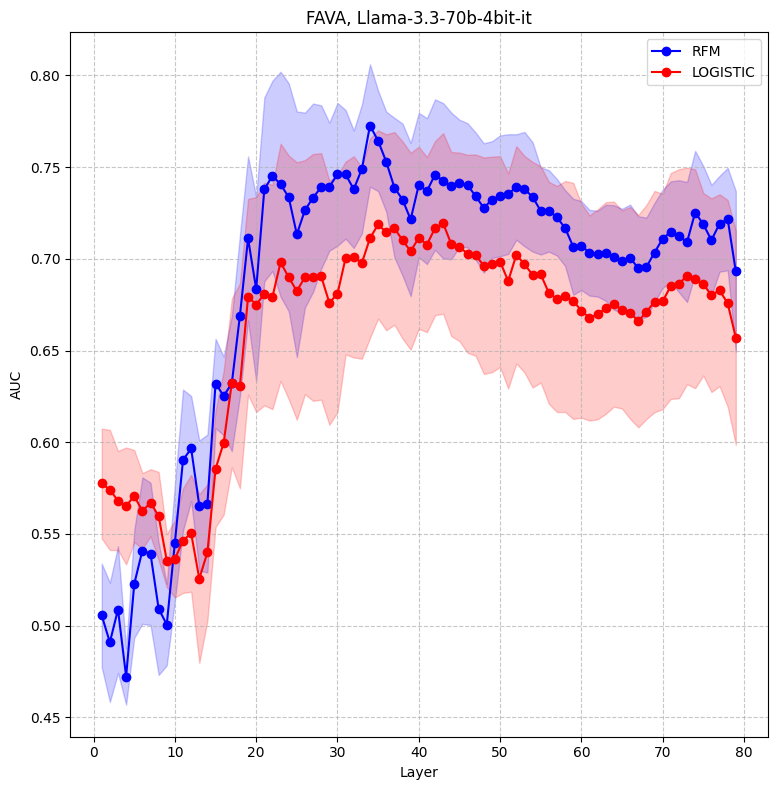

In [14]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os

# Define the range of seeds
seeds = np.arange(5)
methods = ['rfm', 'logistic']
models = ['llama_3.3_70b_4bit_it']
metric = 'auc'
# Initialize dictionaries to store results
all_results = {}

for model in models:
    all_results[model] = {
        'test': {method: {} for method in methods}
    }

    # Load data for each method
    for method in methods:
        # Process each seed
        for s in seeds:
            # Path for test metrics
            path_test = f'{NEURAL_CONTROLLERS_DIR}/results/fava_annotated_results/{model}_{method}_seed_{s}_test_metrics.pkl'
            
            # Check if file exists
            if not os.path.exists(path_test):
                print(f"File not found: {path_test}")
                continue
                
            # Load test results
            with open(path_test, 'rb') as f:
                test_results = pickle.load(f)
            
            # Get layer keys (excluding non-dict entries)
            layers_test = [k for k in test_results.keys() if isinstance(test_results[k], dict)]
            
            # Collect per-layer metrics
            for key in layers_test:
                if key not in all_results[model]['test'][method]:
                    all_results[model]['test'][method][key] = []
                all_results[model]['test'][method][key].append(test_results[key][metric])

# Calculate average accuracies per layer
avg_results = {}
for model in models:
    avg_results[model] = {}
    for method in methods:
        avg_results[model][method] = {}
        for layer, accs in all_results[model]['test'][method].items():
            if accs:  # Check if we have data for this layer
                avg_results[model][method][layer] = {
                    'mean': np.mean(accs),
                    'std': np.std(accs)
                }


# Plot the results
plt.figure(figsize=(15, 8))

# Define colors and alpha values for shading
colors = {'rfm': 'blue', 'logistic': 'red'}
alpha_fill = 0.2  # Alpha transparency for the shaded region

for i, model in enumerate(models):
    plt.subplot(1, 2, i+1)
    
    for method in methods:
        layer_data = avg_results[model][method]
        if layer_data:
            # Sort layers by their numerical value
            layers = sorted([int(layer) for layer in layer_data.keys() if isinstance(layer, int)])
            
            # Extract mean and std for plotting
            means = [layer_data[layer]['mean'] for layer in layers if layer in layer_data]
            stds = [layer_data[layer]['std'] for layer in layers if layer in layer_data]
            
            # Center the layers
            layers = [x+len(layers)+1 for x in layers]

            # Plot the mean line
            plt.plot(layers, means, label=method.upper(), marker='o', color=colors[method])
            
            # Add shaded error region
            plt.fill_between(
                layers, 
                [m - s for m, s in zip(means, stds)],  # lower bound
                [m + s for m, s in zip(means, stds)],  # upper bound
                color=colors[method], 
                alpha=alpha_fill
            )
    
    model_str = model.replace("_", "-")
    model_str = model_str[0].upper() + model_str[1:]
    plt.title(f'FAVA, {model_str}')
    plt.xlabel('Layer')
    plt.ylabel(f'{metric.upper()}')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()

plt.savefig(f'plots/fava_test_{metric}_across_layers.pdf', format='pdf')
plt.show()